In [1]:
# set up path to facenet_pytorch_c
import sys
sys.path.insert(1, '/home/ubuntu/mtcnn')

In [2]:
# facenet_pytorch_c: avoid confusion with system default facenet_pytorch
from facenet_pytorch_c import MTCNN

from tqdm import tqdm
import numpy as np
import os

# pytorch
import torch
import torch.optim as optim
from torch import nn

# data handling
from torch.utils.data import DataLoader

# torchvision libs
import torchvision
from torchvision import datasets
from torchvision import transforms
import PIL


In [4]:
# other custom scripts
import utils
utils.xml_to_numpy('/home/ubuntu/db_proc/db/annotations')

100%|██████████| 2101/2101 [00:00<00:00, 3061.08it/s]

done!


In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available device: " + str(device))

# training hyperparameters
learning_rate = 1e-2
epochs = 400
decay_step = [200, 225, 250, 275, 300, 325, 350, 375]
decay_rate = 0.1
opt = 'Adam'    # either Adam or SGD
batch_size = 128

print_freq = int(3050/batch_size - 5)
print("print freq: {}".format(print_freq))

# data loading parameters
workers = 4

Available device: cuda:0
print freq: 18


In [6]:
x_train, prob_train, bbox_train, x_valid, prob_valid, bbox_valid = utils.get_images(
    '/home/ubuntu/db_proc/db/images',
    '/home/ubuntu/db_proc/db/annotations'
)

100%|██████████| 3540/3540 [00:21<00:00, 161.03it/s]


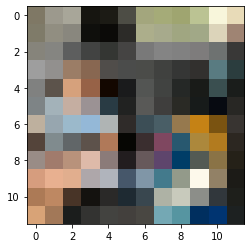

[0 3 5 9]


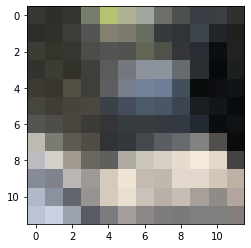

[0 0 0 0]


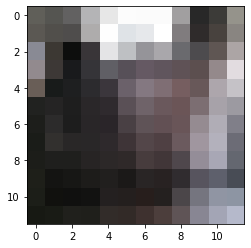

[0 0 0 0]


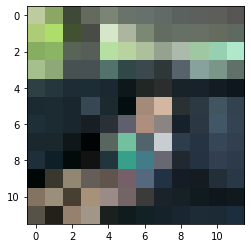

[ 4  5  9 11]


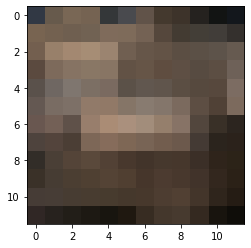

[0 0 0 0]


In [7]:
for i in range(55, 60):
    plt.imshow(x_train[i*5])
    plt.show()
    print(bbox_train[i*5])

In [8]:
class PNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.prelu1 = nn.PReLU(10)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.conv2 = nn.Conv2d(10, 16, kernel_size=3)
        self.prelu2 = nn.PReLU(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        self.prelu3 = nn.PReLU(32)
        self.conv4_1 = nn.Conv2d(32, 2, kernel_size=1)
        self.softmax4_1 = nn.Softmax(dim=1)
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1)

        self.training = True

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        a = self.conv4_1(x) # prob
        a = self.softmax4_1(a)
        b = self.conv4_2(x) # bbox
        return b, a


In [9]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_ds = utils.CIVDS(x_train, prob_train, bbox_train, trsfm=transform_train)

valid_ds = utils.CIVDS(x_valid, prob_valid, bbox_valid, trsfm=transform_valid)

train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    num_workers=workers, shuffle=True
)

valid_loader = DataLoader(
    valid_ds, batch_size=batch_size,
    num_workers=workers, shuffle=False
)

In [10]:
pnet = PNet()
pnet.train()
pnet.to(device)

PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (prelu1): PReLU(num_parameters=10)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (prelu2): PReLU(num_parameters=16)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (prelu3): PReLU(num_parameters=32)
  (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (softmax4_1): Softmax(dim=1)
  (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
)

In [11]:

from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir="/home/ubuntu/tensorLog") # tensorboard writer

prob_lossfn = nn.BCELoss().to(device)
bbox_lossfn = nn.MSELoss().to(device)

optimizer = None

if opt == "Adam":
    print("Optimizer: Adam")
    optimizer = torch.optim.Adam(pnet.parameters(), lr=learning_rate, amsgrad=True)
elif opt == "SGD":
    print("Optimizer: SGD")
    optimizer = torch.optim.SGD(pnet.parameters(), lr=learning_rate, momentum=0.9)
else:
    print("Error")

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_step, gamma=decay_rate)

rl1, rl2 = 0, 0

for epoch in range(1, epochs+1):
    
    for batch_idx, data in enumerate(train_loader):
        
        im, prob, bbox = data
        
        im = im.to(device)
        prob = prob.float().to(device)
        bbox = bbox.float().to(device)
        
        o_bbox, o_prob = pnet(im)
        
        o_bbox = o_bbox.float().squeeze()
        o_prob = o_prob.float().squeeze()
        
        prob_loss = prob_lossfn(o_prob, prob)
        bbox_loss = bbox_lossfn(o_bbox, bbox)
        
        rl1 += prob_loss.item()
        rl2 += bbox_loss.item()
        
        
        all_loss = prob_loss * 0.6 + bbox_loss * 1.2
        
        if batch_idx % print_freq == print_freq-1:
            
            print("epoch: {} probl: {:.4f} bboxl: {:.4f}".format(epoch, rl1/print_freq, rl2/print_freq))
            writer.add_scalar('prob_l', rl1/print_freq, epoch)
            writer.add_scalar('bbox_l', rl2/print_freq, epoch)
            rl1, rl2 = 0, 0

        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
    
    scheduler.step()

    #if epoch % 5 == 0:
    if False:
        save_name = 'epoch-{}.pth.tar'.format(epoch)
        torch.save({
            'epoch': epochs,
            'state_dict': mtcnn.onet.state_dict(),
            'opt_dict': optimizer.state_dict(),
        }, save_name)
        print('Saved model at {}'.format(save_name))

print("finished training")

Optimizer: Adam
epoch: 1 probl: 0.8025 bboxl: 14.9188
epoch: 2 probl: 0.8251 bboxl: 13.5747
epoch: 3 probl: 0.6651 bboxl: 10.5572
epoch: 4 probl: 0.5307 bboxl: 8.2582
epoch: 5 probl: 0.4623 bboxl: 7.9742
epoch: 6 probl: 0.3575 bboxl: 6.3438
epoch: 7 probl: 0.3474 bboxl: 6.5975
epoch: 8 probl: 0.3293 bboxl: 6.4822
epoch: 9 probl: 0.2774 bboxl: 5.5837
epoch: 10 probl: 0.2568 bboxl: 4.8814
epoch: 11 probl: 0.2127 bboxl: 4.2136
epoch: 12 probl: 0.2400 bboxl: 4.5088
epoch: 13 probl: 0.2189 bboxl: 4.1370
epoch: 14 probl: 0.1920 bboxl: 3.7905
epoch: 15 probl: 0.1471 bboxl: 3.1218
epoch: 16 probl: 0.1508 bboxl: 3.1157
epoch: 17 probl: 0.1293 bboxl: 2.9961
epoch: 18 probl: 0.1299 bboxl: 2.9084
epoch: 19 probl: 0.1552 bboxl: 3.2054
epoch: 20 probl: 0.1223 bboxl: 2.6648
epoch: 21 probl: 0.0890 bboxl: 2.2161
epoch: 22 probl: 0.0736 bboxl: 2.0137
epoch: 23 probl: 0.0840 bboxl: 1.9962
epoch: 24 probl: 0.0813 bboxl: 2.0181
epoch: 25 probl: 0.0572 bboxl: 1.6302
epoch: 26 probl: 0.0568 bboxl: 1.6719
ep

epoch: 214 probl: 0.0002 bboxl: 0.2195
epoch: 215 probl: 0.0003 bboxl: 0.2260
epoch: 216 probl: 0.0003 bboxl: 0.2242
epoch: 217 probl: 0.0003 bboxl: 0.2234
epoch: 218 probl: 0.0002 bboxl: 0.2285
epoch: 219 probl: 0.0002 bboxl: 0.2323
epoch: 220 probl: 0.0003 bboxl: 0.2168
epoch: 221 probl: 0.0002 bboxl: 0.2168
epoch: 222 probl: 0.0002 bboxl: 0.2257
epoch: 223 probl: 0.0003 bboxl: 0.2193
epoch: 224 probl: 0.0003 bboxl: 0.2279
epoch: 225 probl: 0.0003 bboxl: 0.2181
epoch: 226 probl: 0.0002 bboxl: 0.2318
epoch: 227 probl: 0.0003 bboxl: 0.2116
epoch: 228 probl: 0.0002 bboxl: 0.2228
epoch: 229 probl: 0.0003 bboxl: 0.2230
epoch: 230 probl: 0.0003 bboxl: 0.2237
epoch: 231 probl: 0.0003 bboxl: 0.2092
epoch: 232 probl: 0.0003 bboxl: 0.2303
epoch: 233 probl: 0.0002 bboxl: 0.2161
epoch: 234 probl: 0.0003 bboxl: 0.2264
epoch: 235 probl: 0.0002 bboxl: 0.2148
epoch: 236 probl: 0.0003 bboxl: 0.2189
epoch: 237 probl: 0.0003 bboxl: 0.2228
epoch: 238 probl: 0.0002 bboxl: 0.2195
epoch: 239 probl: 0.0003 

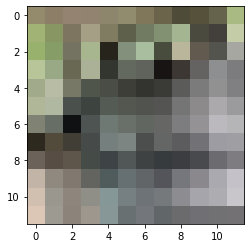

truth: 0, pred: 0
bbox: [0. 0. 0. 0.]


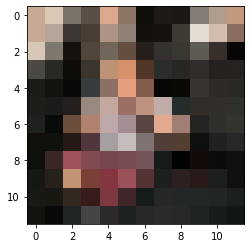

truth: 1, pred: 1
bbox: [ 2.  3.  8. 10.]


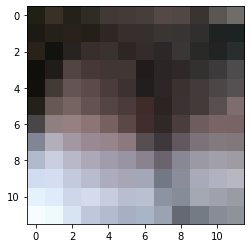

truth: 0, pred: 0
bbox: [-0.  0. -0. -0.]


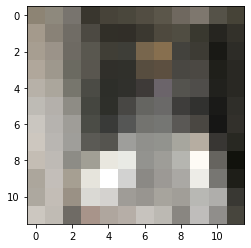

truth: 0, pred: 0
bbox: [ 0. -0.  0.  1.]


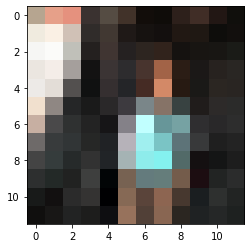

truth: 1, pred: 1
bbox: [ 4.  3. 11. 11.]


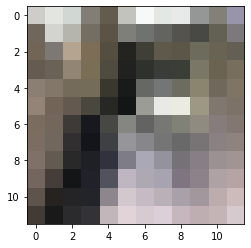

truth: 0, pred: 0
bbox: [-0. -0.  0.  0.]


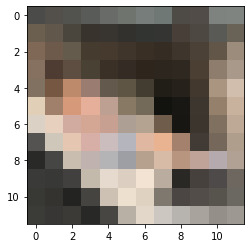

truth: 1, pred: 1
bbox: [ 1.  3.  9. 11.]


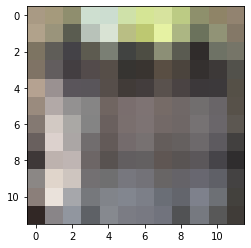

truth: 0, pred: 0
bbox: [-0.  0. -0.  0.]


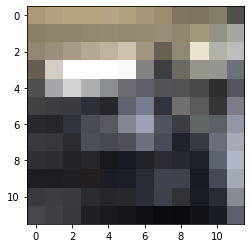

truth: 0, pred: 0
bbox: [0. 0. 1. 0.]


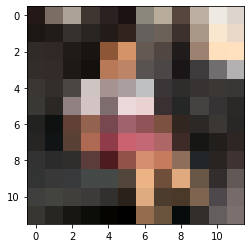

truth: 1, pred: 1
bbox: [2. 1. 8. 9.]


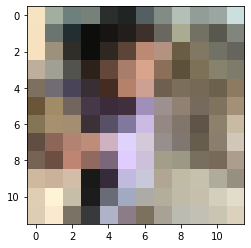

truth: 1, pred: 1
bbox: [ 2.  1. 13. 13.]


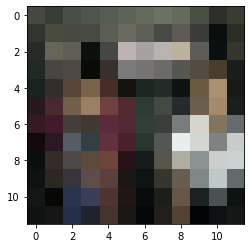

truth: 1, pred: 1
bbox: [ 1.  4.  5. 10.]


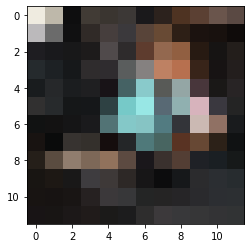

truth: 1, pred: 1
bbox: [ 3.  0. 11.  8.]


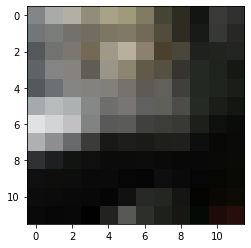

truth: 0, pred: 0
bbox: [-0.  0.  0.  0.]


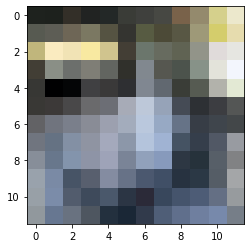

truth: 0, pred: 0
bbox: [-0.  0.  1.  2.]


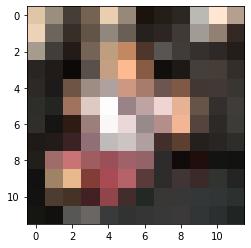

truth: 1, pred: 1
bbox: [ 1.  1. 10.  8.]


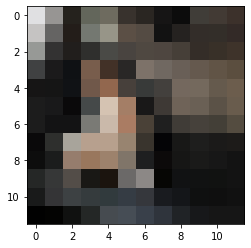

truth: 1, pred: 1
bbox: [2. 2. 7. 8.]


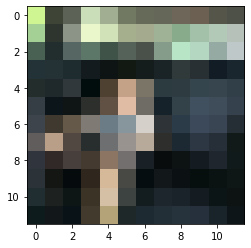

truth: 1, pred: 1
bbox: [2. 4. 7. 9.]
accuracy: 97.2%


In [12]:
total = len(valid_ds)
err = 0
truth = []
pred = []

for idx in range(0, total):
    
    bbox, prob = pnet(valid_ds[idx][0].unsqueeze(0).to(device))
    prob = prob.squeeze()
    if prob[0] > prob[1]:
        prob = 1
    else:
        prob = 0
    
    if prob != prob_valid[idx]:
        err += 1
        
    if idx % 20 == 0:
        plt.imshow(transforms.ToPILImage()(valid_ds[idx][0]))
        plt.show()
        print("truth: {}, pred: {}".format(prob_valid[idx], prob))
        print("bbox: " + str(np.rint(bbox.cpu().detach().squeeze().numpy())))
    
    pred.append(prob)
    truth.append(prob_valid[idx])


print("accuracy: {:.1f}%".format(100*(total-err)/total))
"""
p, r, f1 = utils.f1_score(truth, pred, 0)
print("precision: {:.2f}, recall: {:.2f}, f1: {:.2f}".format(p, r, f1))
print("valid_ds length: {}".format(len(valid_ds)))
print("age dist: ", end='')
""";